In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.api as sm
import matplotlib

# 设置字体为黑体，并解决负号显示问题
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False

# 定义文件夹路径
info_folder = 'StockData/market_info'
data_folder = 'StockData/market_data'

# 创建字典存储股票相关信息数据
market_info = {}
# 读取 market_info 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_{year}.csv'
    file_path = os.path.join(info_folder, file_name)
    if os.path.isfile(file_path):
        data = pd.read_csv(file_path)
        market_info[f'year_{year}'] = data
    else:
        print(f'Warning: File {file_path} does not exist.')

# 创建字典存储股票具体数据
market_data = {}
# 读取 market_data 中的文件
for year in range(2014, 2025):
    file_name = f'hs300stocks_kdata_{year}.csv'
    file_path = os.path.join(data_folder, file_name)
    if os.path.isfile(file_path):
        data = pd.read_csv(file_path)
        market_data[f'year_{year}'] = data
    else:
        print(f'Warning: File {file_path} does not exist.')

# 合并所有年份的市场数据为一个数据框
combined_market_data = pd.concat(market_data.values(), ignore_index=True)

ValueError: No objects to concatenate

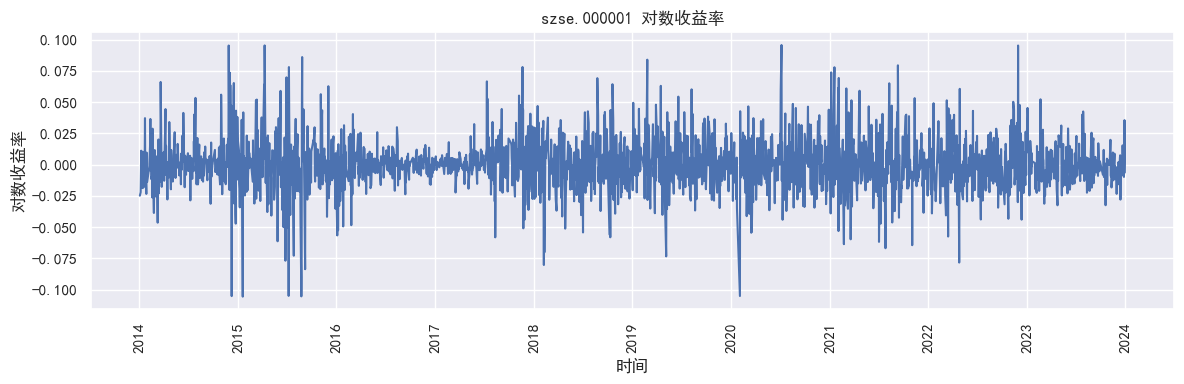

ADF检验 p-value: 0.0
数据是平稳的，可以继续建模。
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5348.99
Distribution:                  Normal   AIC:                           10706.0
Method:            Maximum Likelihood   BIC:                           10729.5
                                        No. Observations:                 2628
Date:                Tue, Nov 05 2024   Df Residuals:                     2627
Time:                        18:59:32   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.7810

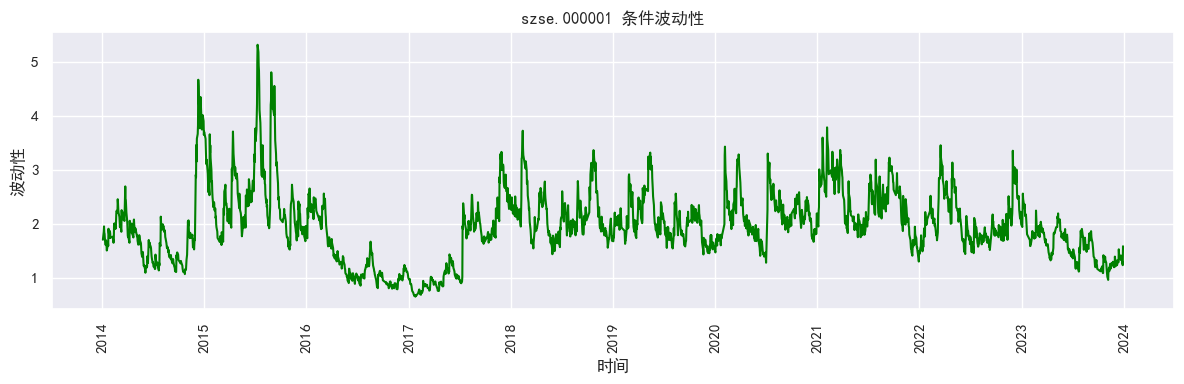

模型特征: {'AIC': 10705.970479930158, 'BIC': 10729.466393448576, 'Log-Likelihood': -5348.985239965079, 'Conditional Volatility': 1         1.715660
2         1.863617
3         1.961450
4         1.846277
5         1.825571
            ...   
711046    2.435814
711047    2.268664
711048    2.146631
711049    2.065504
711050    2.108475
Name: cond_vol, Length: 2628, dtype: float64}


In [14]:
# 选择一个特定的股票代码进行分析
stock_code = 'szse.000001'
stock_data = combined_market_data[combined_market_data['code'] == stock_code].copy()

# 确保时间列为 datetime 类型
stock_data['time'] = pd.to_datetime(stock_data['time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
stock_data = stock_data.sort_values('time')

# 计算对数收益率
stock_data['log_return'] = np.log(stock_data['close']) - np.log(stock_data['close'].shift(1))
stock_data = stock_data.dropna(subset=['log_return'])

# 数据缩放
scaled_log_return = stock_data['log_return'] * 100  # 缩放数据

# 绘制对数收益率
plt.figure(figsize=(12, 4))
sns.lineplot(data=stock_data, x='time', y='log_return')
plt.title(f'{stock_code} 对数收益率')
plt.xlabel('时间')
plt.ylabel('对数收益率')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ADF检验
adf_test = sm.tsa.stattools.adfuller(stock_data['log_return'])
print("ADF检验 p-value:", adf_test[1])

# 如果p-value很小，说明数据是平稳的
if adf_test[1] < 0.05:
    print("数据是平稳的，可以继续建模。")
else:
    print("数据不是平稳的，请考虑进行差分处理。")

# 拟合EGARCH模型
model = arch_model(scaled_log_return, vol='EGARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# 输出模型参数
print(model_fit.summary())

# 提取条件波动性
conditional_volatility = model_fit.conditional_volatility

# 将条件波动性添加到原始数据中
stock_data['conditional_volatility'] = conditional_volatility

# 绘制条件波动性
plt.figure(figsize=(12, 4))
sns.lineplot(data=stock_data, x='time', y='conditional_volatility', color='green')
plt.title(f'{stock_code} 条件波动性')
plt.xlabel('时间')
plt.ylabel('波动性')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 特征提取
features = {
    'AIC': model_fit.aic,
    'BIC': model_fit.bic,
    'Log-Likelihood': model_fit.loglikelihood,
    'Conditional Volatility': conditional_volatility  # 最后一个值
}
print("模型特征:", features )